In [560]:
import imp
imp.reload(game)

<module 'game' from '/home/manolo/Philosophy/Writings/Software/Signal/game.py'>

In [2]:
import game
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import itertools as it

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 1. Setting things up

Let's take a look at `game.py`, which we use to create games. Right now, Signal only does cheap-talk games with a chance player. That is, games in which the state the sender observes is exogenously generated, following a certain probablitiy distribution.

We first generate payoff matrices for sender and receiver. The cell $c_{ij}$ in the sender (receiver) payoff matrix gives the payoff for the sender (receiver) when act $A_j$ is done in state $S_i$.

In [539]:
sender = np.identity(3)
receiver = np.identity(3)
state_chances = np.array([1/3, 1/3, 1/3])

So, 3 equiprobable (as per state_chances) states and 3 acts (that's why the payoff matrices are square), and sender and receiver get 1 payoff unit when act $A_i$ is performed in state $S_i$, 0 otherwise. That's why both payoff matrices are the identity matrix.

What we now need is to decide which strategies will each type in the sender/receiver populations play, and calculate the average payoff for each combination of sender and receiver strategies. `s.Chance` takes care of that:

In [540]:
simple_game = game.Chance(state_chances, sender, receiver, 3) # The 3 gives the number of available messages

One common choice is to have one type in each of the populations for each possible pure strategy available to them:

In [541]:
sender_strats = simple_game.sender_pure_strats()
receiver_strats = simple_game.receiver_pure_strats()


But this is not the only choice. Conceivably, one might want to add into `sender_strats` a type of senders following a mixed strategy, or ditto for the receiver. One might add such possibilities by hand into the strats arrays, or delete a number of pure strats, or create a strats array from scratch, etc. 

# Simulating Evolution

Once we have the two strats arrays we want, we can create a population game. From here on `game.Evolve` takes over:

In [542]:
simple_evo = game.Evolve(simple_game, sender_strats, receiver_strats)

All right, we can now actually run one of the ODE solvers available in scipy with this object. We create two random population vectors as the initial state, then run, e.g., `scipy.integrate.odeint`. We also need to give a vector of times for which population snapshots will be calculated (other solvers in `scipy.integrate` have a slightly different API):

In [543]:
sender_init = simple_evo.random_sender()
receiver_init = simple_evo.random_receiver()
times = np.arange(1000) # times from 0 to 999, at 1 time-unit increments

Right now, Signal calculates the two-population replicator(-mutator) dynamics, in continuous or discrete time. It is able to use both `scipy.integrate.odeint` and `scipy.integrate.ode` for this. Let's evolve those two random initial population vectors, following the replicator dynamics in continuous time, using `odeint`:

In [544]:
results = simple_evo.replicator_odeint(sender_init, receiver_init, times)

`results` gives the results of the simulations. If you want the additional output that `odeint` can provide, you can pass the `full_output=True` flag to `replicator_odeint`just as you would to `odeint`. The same goes for other additional input to `odeint`.

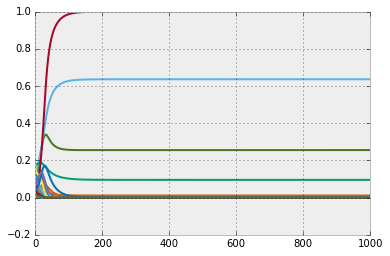

In [545]:
plt.plot(results);

This popnulation will no longer evolve. We can now check what it is they are doing in the final state:

In [546]:
sender_final, receiver_final = simple_evo.vector_to_populations(results[-1])
# This splits the vector that the solver outputs into two population vectors
winning_sender = sender_strats[sender_final.argmax()]
winning_receiver = receiver_strats[receiver_final.argmax()]
# This gives the strategies with the highest frequency (which we know is 1)
# for sender and receiver in the final population state
print("{}\n\n{}".format(winning_sender, winning_receiver))

[[ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


Sender and receiver are engaged in a signaling system. We can also check directly the mutual info between states and acts in the final snapshot:

In [18]:
import analyze
info = analyze.Information(simple_game, winning_sender, winning_receiver)
info.mutual_info_states_acts()

NameError: name 'simple_game' is not defined

1.58 (that is, log2(3)) bits is the entropy of states, which is fully recovered in the mutual information between states and act: a signaling system, as expected.

But we know that a small proportion of random starting points in the "simple game" do not evolve to signaling systems. This percentage, according to Huttegger et al. (2010, p. 183) is about 4.7%. Let's replicate their result.

In [557]:
final_info = []
for i in range(1000):
    sender_init = simple_evo.random_sender()
    receiver_init = simple_evo.random_receiver()
    data = simple_evo.replicator_odeint(sender_init, receiver_init, times)
    sender_final, receiver_final = simple_evo.vector_to_populations(data[-1])
    sender_final_info = simple_evo.sender_to_mixed_strat(sender_final)
    receiver_final_info = simple_evo.receiver_to_mixed_strat(receiver_final)
    info = analyze.Information(simple_game, sender_final_info, receiver_final_info)
    final_info.append(info.mutual_info_states_acts())

We have now the mutual info between states and acts at 1000 end points:

As the plot shows, there are no intermediate values between signaling systems (at 1.58 bits) and the partially pooling configuration at 0.9 bits. So, to calculate the proportion of pooling equilibria, we can look at just that.

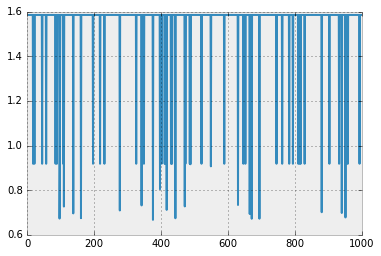

In [558]:
plt.plot(final_info);

In [559]:
sum(np.array(final_info) < 1.58)/1000

0.057000000000000002

Close enough!

# Games without chance player

Let's now work with a game in which the sender has an endogenously generated state. I.e., a sender type will now be individuated by a state together with a probability vector over the set of messages. Receivers are as in the games with chance player discussed above:

In [19]:
import imp
imp.reload(game)
imp.reload(analyze)

<module 'analyze' from '/home/manolo/Philosophy/Writings/Software/Signal/analyze.py'>

In [20]:
sender = np.identity(3)
receiver = np.identity(3)

In [21]:
simple_nonchance = game.NonChance(sender, receiver, 3)

In [22]:
sender_strats = simple_nonchance.sender_pure_strats()
receiver_strats = simple_nonchance.receiver_pure_strats()

In [23]:
avgpayoff = simple_nonchance.avg_payoffs(sender_strats, receiver_strats)

In [24]:
nc_evolve = game.Evolve(simple_nonchance, sender_strats, receiver_strats)

In [25]:
sender_init = nc_evolve.random_sender()
receiver_init = nc_evolve.random_receiver()
times = np.arange(1000)

In [26]:
results = nc_evolve.replicator_odeint(sender_init, receiver_init, times)

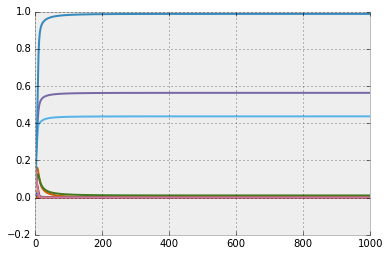

In [27]:
plt.plot(results);

In [28]:
sender_final, receiver_final = nc_evolve.vector_to_populations(results[-1])
# This splits the vector that the solver outputs into two population vectors
sender_final_strat = nc_evolve.sender_to_mixed_strat(sender_final)
receiver_final_strat = nc_evolve.receiver_to_mixed_strat(receiver_final)
print("{}\n\n{}".format(sender_final_strat, receiver_final_strat))

[[  7.0798e-13   5.4881e-12   5.6323e-01]
 [  2.3108e-12   5.6894e-08   3.6256e-12]
 [  4.3677e-01   1.1729e-12   7.6895e-13]]

[[  9.6013e-12   4.5485e-12   1.0000e+00]
 [  7.8544e-04   9.8758e-01   1.1634e-02]
 [  1.0000e+00   9.5805e-12   4.5693e-12]]


In [32]:
ci = analyze.CommonInterest(simple_nonchance)

In [35]:
ci.C_chance()

ChanceNodeError: This is not a chance-node game.

In [440]:
simple_nonchance.sender_payoff_matrix.dot(receiver_for_sender)

array([ 0.,  1.,  0.])

In [400]:
payoffs = np.arange(9).reshape(3,3)

In [401]:
payoffs

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [410]:
senderstrat[0][:, None] * payoffs.dot(np.array([1/3, 0, 2/3])[:, None])

array([[ 0.    ],
       [ 4.3333],
       [ 0.    ]])

In [554]:
simple_evo.sender_to_mixed_strat(receiver_final)

array([[  7.0854e-89,   1.0000e+00,   5.4050e-87],
       [  1.0000e+00,   4.7875e-89,   3.2510e-89],
       [  4.4606e-88,   4.1588e-86,   1.0000e+00]])

In [555]:
final_info

[1.5849625007211561,
 1.5849625007211561,
 1.5849625007211561,
 1.5849625007211561,
 1.5849625007211561,
 1.5849625007211561,
 1.5849625007211561,
 1.5849625007211561,
 1.5849625007211561,
 1.5849625007211561]